<a href="https://colab.research.google.com/github/PETEROA/AutoML/blob/main/Search_Space_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installation
!pip install torch torchvision -q
!pip install matplotlib seaborn pandas numpy -q
!pip install pyyaml -q

In [ ]:
import os
from google.colab import drive

# Check if /content/drive exists and is not empty, then remove it
# This ensures a clean mount point for Google Drive.
if os.path.exists('/content/drive') and os.path.isdir('/content/drive'):
    if os.listdir('/content/drive'):
        print("Clearing existing /content/drive directory before mounting...")
        os.system('rm -rf /content/drive')
        print("/content/drive cleared.")

drive.mount('/content/drive', force_remount=True)

Clearing existing /content/drive directory before mounting...
/content/drive cleared.
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import yaml
from typing import Dict, List, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Import utilities
import sys
sys.path.append('/content/drive/MyDrive/AutoML')  # Adjust path

try:
    from Utils import *
    print("✓ Utils loaded")
except:
    print("⚠ Utils not found, using minimal functions")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Setup directories
OUTPUT_DIR = Path('/content/drive/MyDrive/AutoML/outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONFIGS_DIR = OUTPUT_DIR / 'configs'
CONFIGS_DIR.mkdir(exist_ok=True)

RESULTS_DIR = OUTPUT_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

✓ Utils loaded
Output directory: /content/drive/MyDrive/AutoML/outputs


In [ ]:
#Load results from notebook
# Try to load distillation recommendations
recommendations_file = RESULTS_DIR / 'distillation_recommendations.json'

if recommendations_file.exists():
    with open(recommendations_file, 'r') as f:
        distill_recommendations = json.load(f)
    print("✓ Loaded distillation recommendations from Notebook 2")
    print(f"\n  Best method: {distill_recommendations.get('best_method', 'N/A')}")
    print(f"  Best accuracy: {distill_recommendations.get('best_accuracy', 0):.2f}%")
    print(f"  Recommended temp range: {distill_recommendations.get('recommended_temperature_range', [])}")
    print(f"  Recommended alpha range: {distill_recommendations.get('recommended_alpha_range', [])}")
else:
    print("⚠ Distillation recommendations not found")
    print("  Using default ranges")
    distill_recommendations = {
        'recommended_temperature_range': [2.0, 3.0, 4.0, 5.0],
        'recommended_alpha_range': [0.3, 0.5, 0.7, 0.9]
    }

⚠ Distillation recommendations not found
  Using default ranges


In [ ]:
#Define architecture search space
class ArchitectureSearchSpace:
    """
    Defines the architecture search space for student models
    """
    def __init__(self):
        # Base architecture options
        self.base_architectures = [
            'resnet18',
            'mobilenet_v2',
            'efficientnet_b0'
        ]

        # Width multipliers (scale number of channels)
        self.width_multipliers = [0.25, 0.5, 0.75, 1.0]

        # Depth multipliers (scale number of layers)
        self.depth_multipliers = [0.5, 0.75, 1.0]

        # Resolution multipliers (input image size)
        self.resolution_multipliers = [0.75, 1.0, 1.25]  # 224 * multiplier

    def get_config(self) -> Dict:
        return {
            'base_architectures': self.base_architectures,
            'width_multipliers': self.width_multipliers,
            'depth_multipliers': self.depth_multipliers,
            'resolution_multipliers': self.resolution_multipliers
        }

    def sample_random(self) -> Dict:
        """Sample a random architecture configuration"""
        return {
            'base_arch': np.random.choice(self.base_architectures),
            'width_mult': np.random.choice(self.width_multipliers),
            'depth_mult': np.random.choice(self.depth_multipliers),
            'resolution_mult': np.random.choice(self.resolution_multipliers)
        }

    def get_total_combinations(self) -> int:
        """Total number of architecture configurations"""
        return (len(self.base_architectures) *
                len(self.width_multipliers) *
                len(self.depth_multipliers) *
                len(self.resolution_multipliers))

arch_space = ArchitectureSearchSpace()
print("\n" + "="*60)
print("ARCHITECTURE SEARCH SPACE")
print("="*60)
print(f"Base architectures: {arch_space.base_architectures}")
print(f"Width multipliers: {arch_space.width_multipliers}")
print(f"Depth multipliers: {arch_space.depth_multipliers}")
print(f"Resolution multipliers: {arch_space.resolution_multipliers}")
print(f"\nTotal combinations: {arch_space.get_total_combinations():,}")

# Show sample
print("\nExample sampled architecture:")
sample = arch_space.sample_random()
for k, v in sample.items():
    print(f"  {k}: {v}")


ARCHITECTURE SEARCH SPACE
Base architectures: ['resnet18', 'mobilenet_v2', 'efficientnet_b0']
Width multipliers: [0.25, 0.5, 0.75, 1.0]
Depth multipliers: [0.5, 0.75, 1.0]
Resolution multipliers: [0.75, 1.0, 1.25]

Total combinations: 108

Example sampled architecture:
  base_arch: efficientnet_b0
  width_mult: 1.0
  depth_mult: 1.0
  resolution_mult: 1.25


In [ ]:
#Define Distillation Strategy Search Space
class DistillationSearchSpace:
    """
    Defines the distillation strategy search space
    Based on findings from Notebook 2
    """
    def __init__(self, recommendations: Dict):
        # Loss types
        self.loss_types = [
            'kl_divergence',          # Standard KD
            'mse',                     # Mean squared error
            'attention_transfer',      # Attention-based
            'feature_matching'         # Intermediate features
        ]

        # Temperature values (from Notebook 2 recommendations)
        self.temperatures = recommendations.get(
            'recommended_temperature_range',
            [2.0, 3.0, 4.0, 5.0]
        )

        # Alpha values (weight of distillation loss)
        self.alphas = recommendations.get(
            'recommended_alpha_range',
            [0.3, 0.5, 0.7, 0.9]
        )

        # Whether to use distillation at all
        self.use_distillation = [True, False]

    def get_config(self) -> Dict:
        return {
            'loss_types': self.loss_types,
            'temperatures': self.temperatures,
            'alphas': self.alphas,
            'use_distillation': self.use_distillation
        }

    def sample_random(self) -> Dict:
        """Sample a random distillation configuration"""
        use_distill = np.random.choice(self.use_distillation)

        if use_distill:
            return {
                'use_distillation': True,
                'loss_type': np.random.choice(self.loss_types),
                'temperature': np.random.choice(self.temperatures),
                'alpha': np.random.choice(self.alphas)
            }
        else:
            return {
                'use_distillation': False,
                'loss_type': None,
                'temperature': None,
                'alpha': None
            }

    def get_total_combinations(self) -> int:
        """Total number of distillation configurations"""
        with_distill = (len(self.loss_types) *
                       len(self.temperatures) *
                       len(self.alphas))
        without_distill = 1
        return with_distill + without_distill

distill_space = DistillationSearchSpace(distill_recommendations)

print("\n" + "="*60)
print("DISTILLATION STRATEGY SEARCH SPACE")
print("="*60)
print(f"Loss types: {distill_space.loss_types}")
print(f"Temperatures: {distill_space.temperatures}")
print(f"Alpha values: {distill_space.alphas}")
print(f"\nTotal combinations: {distill_space.get_total_combinations():,}")

# Show samples
print("\nExample distillation strategies:")
for i in range(3):
    sample = distill_space.sample_random()
    print(f"\n  Strategy {i+1}:")
    for k, v in sample.items():
        print(f"    {k}: {v}")


DISTILLATION STRATEGY SEARCH SPACE
Loss types: ['kl_divergence', 'mse', 'attention_transfer', 'feature_matching']
Temperatures: [2.0, 3.0, 4.0, 5.0]
Alpha values: [0.3, 0.5, 0.7, 0.9]

Total combinations: 65

Example distillation strategies:

  Strategy 1:
    use_distillation: False
    loss_type: None
    temperature: None
    alpha: None

  Strategy 2:
    use_distillation: True
    loss_type: feature_matching
    temperature: 2.0
    alpha: 0.3

  Strategy 3:
    use_distillation: False
    loss_type: None
    temperature: None
    alpha: None


In [ ]:
# Define Hypaparameter Search Space
class TrainingSearchSpace:
    """
    Defines the training hyperparameter search space
    """
    def __init__(self):
        # Learning rates
        self.learning_rates = [1e-4, 5e-4, 1e-3, 5e-3]

        # Batch sizes
        self.batch_sizes = [16, 32, 64, 128]

        # Optimizers
        self.optimizers = ['adam', 'sgd', 'adamw']

        # Weight decay
        self.weight_decays = [0.0, 1e-5, 1e-4, 1e-3]

        # Data augmentation strength
        self.augmentation_strengths = ['none', 'light', 'medium', 'strong']

    def get_config(self) -> Dict:
        return {
            'learning_rates': self.learning_rates,
            'batch_sizes': self.batch_sizes,
            'optimizers': self.optimizers,
            'weight_decays': self.weight_decays,
            'augmentation_strengths': self.augmentation_strengths
        }

    def sample_random(self) -> Dict:
        """Sample random training hyperparameters"""
        return {
            'learning_rate': np.random.choice(self.learning_rates),
            'batch_size': np.random.choice(self.batch_sizes),
            'optimizer': np.random.choice(self.optimizers),
            'weight_decay': np.random.choice(self.weight_decays),
            'augmentation': np.random.choice(self.augmentation_strengths)
        }

    def get_total_combinations(self) -> int:
        """Total number of training configurations"""
        return (len(self.learning_rates) *
                len(self.batch_sizes) *
                len(self.optimizers) *
                len(self.weight_decays) *
                len(self.augmentation_strengths))

training_space = TrainingSearchSpace()

print("\n" + "="*60)
print("TRAINING HYPERPARAMETER SEARCH SPACE")
print("="*60)
print(f"Learning rates: {training_space.learning_rates}")
print(f"Batch sizes: {training_space.batch_sizes}")
print(f"Optimizers: {training_space.optimizers}")
print(f"Weight decays: {training_space.weight_decays}")
print(f"Augmentation: {training_space.augmentation_strengths}")
print(f"\nTotal combinations: {training_space.get_total_combinations():,}")

# Show sample
print("\nExample training config:")
sample = training_space.sample_random()
for k, v in sample.items():
    print(f"  {k}: {v}")


TRAINING HYPERPARAMETER SEARCH SPACE
Learning rates: [0.0001, 0.0005, 0.001, 0.005]
Batch sizes: [16, 32, 64, 128]
Optimizers: ['adam', 'sgd', 'adamw']
Weight decays: [0.0, 1e-05, 0.0001, 0.001]
Augmentation: ['none', 'light', 'medium', 'strong']

Total combinations: 768

Example training config:
  learning_rate: 0.0001
  batch_size: 128
  optimizer: sgd
  weight_decay: 1e-05
  augmentation: medium


In [ ]:
# Complete Search Space Config
class CompleteSearchSpace:
    """
    Combined search space for NAS
    """
    def __init__(self, arch_space, distill_space, training_space):
        self.arch_space = arch_space
        self.distill_space = distill_space
        self.training_space = training_space

    def sample_random_configuration(self) -> Dict:
        """Sample a complete random configuration"""
        return {
            'architecture': self.arch_space.sample_random(),
            'distillation': self.distill_space.sample_random(),
            'training': self.training_space.sample_random()
        }

    def get_total_combinations(self) -> int:
        """Total search space size"""
        return (self.arch_space.get_total_combinations() *
                self.distill_space.get_total_combinations() *
                self.training_space.get_total_combinations())

    def get_config_dict(self) -> Dict:
        """Get complete configuration as dictionary"""
        return {
            'architecture': self.arch_space.get_config(),
            'distillation': self.distill_space.get_config(),
            'training': self.training_space.get_config()
        }

# Create complete search space
complete_space = CompleteSearchSpace(arch_space, distill_space, training_space)

print("\n" + "="*60)
print("COMPLETE SEARCH SPACE SUMMARY")
print("="*60)
print(f"Architecture combinations: {arch_space.get_total_combinations():,}")
print(f"Distillation combinations: {distill_space.get_total_combinations():,}")
print(f"Training combinations: {training_space.get_total_combinations():,}")
print(f"\n{'='*60}")
print(f"TOTAL SEARCH SPACE SIZE: {complete_space.get_total_combinations():,}")
print(f"{'='*60}")
print("\n⚠ This is too large to exhaustively search!")
print("   → NAS is essential for efficient exploration")


COMPLETE SEARCH SPACE SUMMARY
Architecture combinations: 108
Distillation combinations: 65
Training combinations: 768

TOTAL SEARCH SPACE SIZE: 5,391,360

⚠ This is too large to exhaustively search!
   → NAS is essential for efficient exploration


In [ ]:
# Hardware Constraints
class HardwareConstraints:
    """
    Define hardware deployment targets and constraints
    """
    def __init__(self):
        self.targets = {
            'cloud_gpu': {
                'max_latency_ms': 50,
                'max_memory_mb': 1000,
                'max_params': 50e6,  # 50M parameters
                'min_accuracy': 85.0
            },
            'edge_device': {
                'max_latency_ms': 100,
                'max_memory_mb': 250,
                'max_params': 10e6,  # 10M parameters
                'min_accuracy': 80.0
            },
            'mobile': {
                'max_latency_ms': 200,
                'max_memory_mb': 100,
                'max_params': 5e6,  # 5M parameters
                'min_accuracy': 75.0
            }
        }

    def check_constraints(self, target: str, metrics: Dict) -> bool:
        """
        Check if a model satisfies hardware constraints
        """
        if target not in self.targets:
            return False

        constraints = self.targets[target]

        checks = [
            metrics.get('latency_ms', float('inf')) <= constraints['max_latency_ms'],
            metrics.get('memory_mb', float('inf')) <= constraints['max_memory_mb'],
            metrics.get('params', float('inf')) <= constraints['max_params'],
            metrics.get('accuracy', 0) >= constraints['min_accuracy']
        ]

        return all(checks)

    def get_config(self) -> Dict:
        return self.targets

hardware_constraints = HardwareConstraints()

print("\n" + "="*60)
print("HARDWARE DEPLOYMENT TARGETS")
print("="*60)

for target, constraints in hardware_constraints.targets.items():
    print(f"\n{target.upper()}:")
    print(f"  Max Latency: {constraints['max_latency_ms']} ms")
    print(f"  Max Memory: {constraints['max_memory_mb']} MB")
    print(f"  Max Parameters: {constraints['max_params']/1e6:.1f}M")
    print(f"  Min Accuracy: {constraints['min_accuracy']}%")


HARDWARE DEPLOYMENT TARGETS

CLOUD_GPU:
  Max Latency: 50 ms
  Max Memory: 1000 MB
  Max Parameters: 50.0M
  Min Accuracy: 85.0%

EDGE_DEVICE:
  Max Latency: 100 ms
  Max Memory: 250 MB
  Max Parameters: 10.0M
  Min Accuracy: 80.0%

MOBILE:
  Max Latency: 200 ms
  Max Memory: 100 MB
  Max Parameters: 5.0M
  Min Accuracy: 75.0%


In [ ]:
# Multi Objective Optimization Setup
class ObjectiveWeights:
    """
    Define weights for multi-objective optimization
    """
    def __init__(self):
        # Default weights
        self.weights = {
            'accuracy': 0.4,      # Maximize
            'latency': 0.3,       # Minimize
            'model_size': 0.2,    # Minimize
            'params': 0.1         # Minimize
        }

        # Optimization directions
        self.directions = {
            'accuracy': 'maximize',
            'latency': 'minimize',
            'model_size': 'minimize',
            'params': 'minimize'
        }

    def compute_fitness(self, metrics: Dict, normalize: bool = True) -> float:
        """
        Compute weighted fitness score

        Args:
            metrics: Dictionary with accuracy, latency_ms, model_size_mb, params
            normalize: Whether to normalize metrics
        """
        if normalize:
            # Normalize to [0, 1] range
            norm_accuracy = metrics.get('accuracy', 0) / 100.0
            norm_latency = 1.0 / (1.0 + metrics.get('latency_ms', 1))
            norm_size = 1.0 / (1.0 + metrics.get('model_size_mb', 1))
            norm_params = 1.0 / (1.0 + metrics.get('params', 1) / 1e6)

            normalized = {
                'accuracy': norm_accuracy,
                'latency': norm_latency,
                'model_size': norm_size,
                'params': norm_params
            }
        else:
            normalized = metrics

        # Weighted sum
        fitness = sum(
            self.weights[k] * normalized.get(k, 0)
            for k in self.weights.keys()
        )

        return fitness

    def get_config(self) -> Dict:
        return {
            'weights': self.weights,
            'directions': self.directions
        }

objectives = ObjectiveWeights()

print("\n" + "="*60)
print("MULTI-OBJECTIVE OPTIMIZATION")
print("="*60)
print("\nObjective weights:")
for obj, weight in objectives.weights.items():
    direction = objectives.directions[obj]
    print(f"  {obj}: {weight:.2f} ({direction})")

# Test fitness computation
test_metrics = {
    'accuracy': 85.0,
    'latency_ms': 50.0,
    'model_size_mb': 100.0,
    'params': 10e6
}
fitness = objectives.compute_fitness(test_metrics)
print(f"\nExample fitness score: {fitness:.4f}")


MULTI-OBJECTIVE OPTIMIZATION

Objective weights:
  accuracy: 0.40 (maximize)
  latency: 0.30 (minimize)
  model_size: 0.20 (minimize)
  params: 0.10 (minimize)

Example fitness score: 0.3570


In [ ]:
# A placeholder Encoder class (to be properly defined later)
class PlaceholderEncoder:
    def get_dimension(self):
        # This should ideally return the actual vector dimension based on the search spaces.
        # For now, we return a dummy value to avoid a NameError.
        # The actual implementation would involve analyzing the complete_space structure.
        return 0 # Placeholder dimension

# Instantiate the placeholder encoder
encoder = PlaceholderEncoder()

# Save Complete Search Space Config
# Compile complete search space configuration
search_space_config = {
    'metadata': {
        'created_date': str(pd.Timestamp.now()),
        'total_combinations': complete_space.get_total_combinations(),
        'vector_dimension': encoder.get_dimension(),
        'source_notebook': 'Notebook 3: Search Space Design'
    },
    'search_spaces': {
        'architecture': arch_space.get_config(),
        'distillation': distill_space.get_config(),
        'training': training_space.get_config()
    },
    'hardware_constraints': hardware_constraints.get_config(),
    'objectives': objectives.get_config(),
    'from_notebook_2': distill_recommendations
}

# Save to JSON
config_file = CONFIGS_DIR / 'search_space_config.json'
with open(config_file, 'w') as f:
    json.dump(search_space_config, f, indent=2)

print("\n" + "="*60)
print("SEARCH SPACE CONFIGURATION SAVED")
print("="*60)
print(f"\nSaved to: {config_file}")
print(f"\nConfiguration includes:")
print(f"  ✓ Architecture search space ({arch_space.get_total_combinations():,} configs)")
print(f"  ✓ Distillation search space ({distill_space.get_total_combinations():,} configs)")
print(f"  ✓ Training search space ({training_space.get_total_combinations():,} configs)")
print(f"  ✓ Hardware constraints (3 targets)")
print(f"  ✓ Multi-objective weights")
print(f"  ✓ Encoding dimension: {encoder.get_dimension()}")


SEARCH SPACE CONFIGURATION SAVED

Saved to: /content/drive/MyDrive/AutoML/outputs/configs/search_space_config.json

Configuration includes:
  ✓ Architecture search space (108 configs)
  ✓ Distillation search space (65 configs)
  ✓ Training search space (768 configs)
  ✓ Hardware constraints (3 targets)
  ✓ Multi-objective weights
  ✓ Encoding dimension: 0


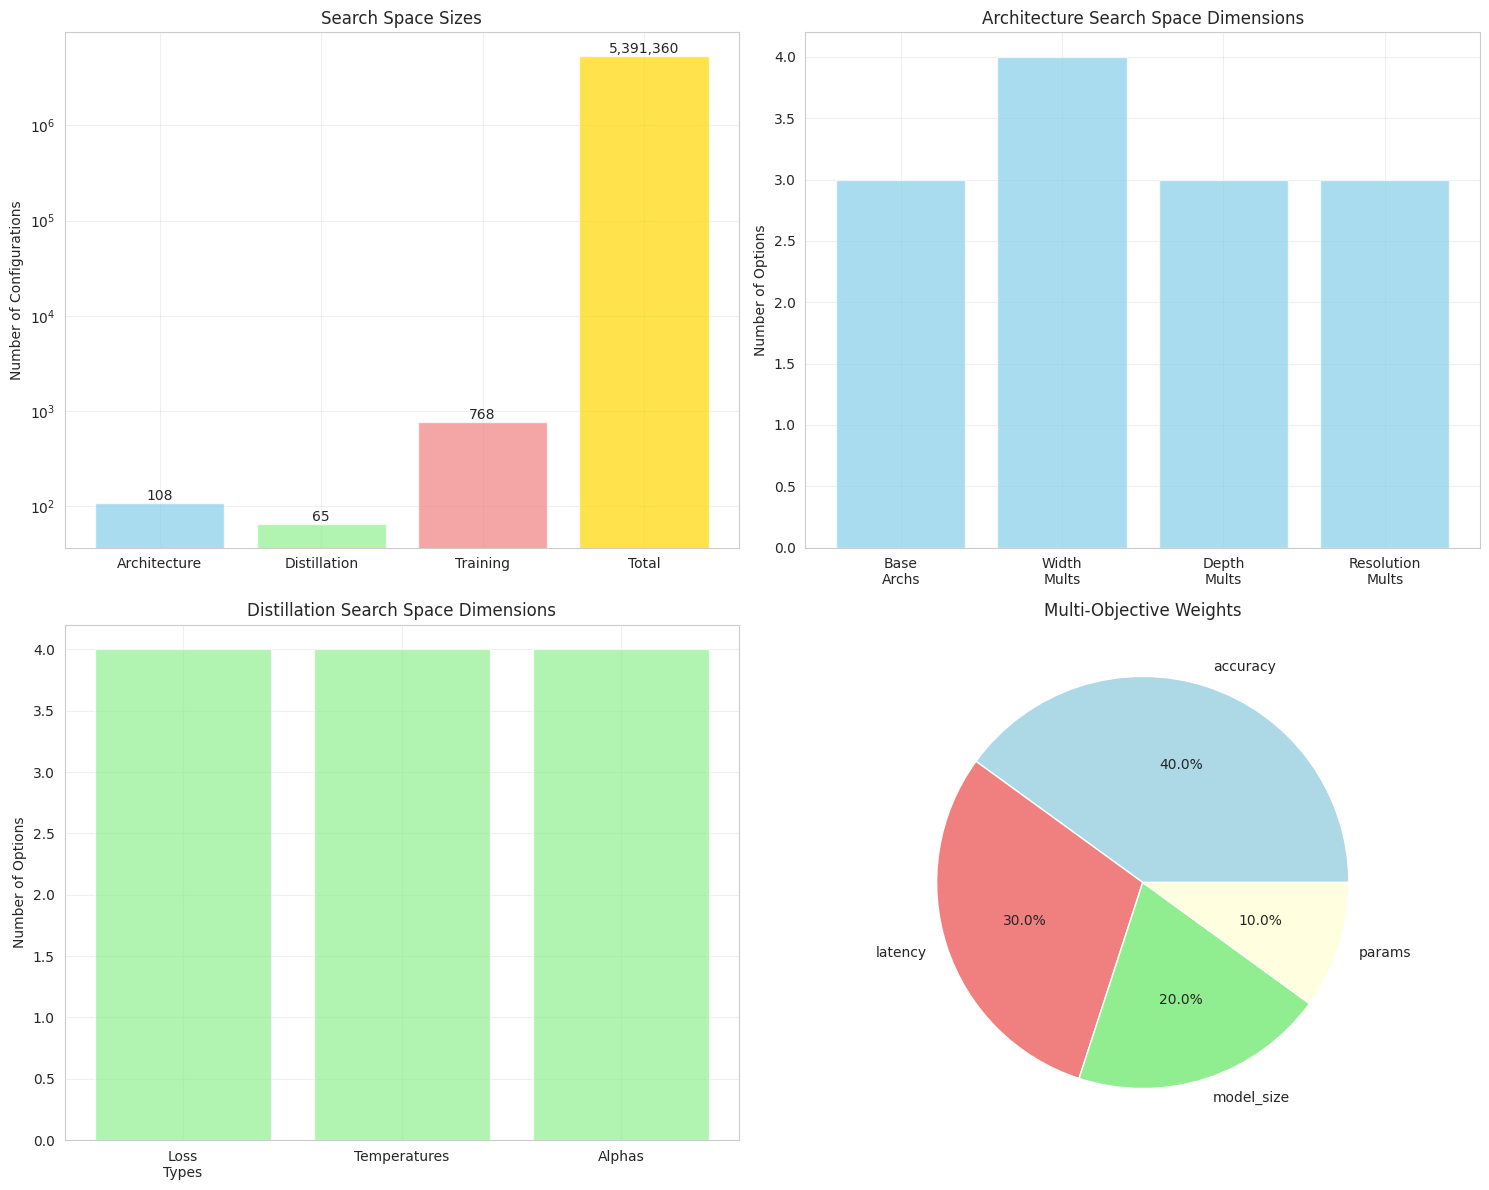


✓ Visualization saved to: /content/drive/MyDrive/AutoML/outputs/search_space_structure.png


In [ ]:
# Visualize Search Space Structure
# Visualize search space dimensions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Search space sizes
categories = ['Architecture', 'Distillation', 'Training', 'Total']
sizes = [
    arch_space.get_total_combinations(),
    distill_space.get_total_combinations(),
    training_space.get_total_combinations(),
    complete_space.get_total_combinations()
]

colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']
axes[0, 0].bar(categories, sizes, color=colors, alpha=0.7)
axes[0, 0].set_ylabel('Number of Configurations')
axes[0, 0].set_title('Search Space Sizes')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

for i, (cat, size) in enumerate(zip(categories, sizes)):
    axes[0, 0].text(i, size, f'{size:,}', ha='center', va='bottom')

# Plot 2: Architecture parameters
arch_params = ['Base\nArchs', 'Width\nMults', 'Depth\nMults', 'Resolution\nMults']
arch_counts = [
    len(arch_space.base_architectures),
    len(arch_space.width_multipliers),
    len(arch_space.depth_multipliers),
    len(arch_space.resolution_multipliers)
]

axes[0, 1].bar(arch_params, arch_counts, color='skyblue', alpha=0.7)
axes[0, 1].set_ylabel('Number of Options')
axes[0, 1].set_title('Architecture Search Space Dimensions')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distillation parameters
distill_params = ['Loss\nTypes', 'Temperatures', 'Alphas']
distill_counts = [
    len(distill_space.loss_types),
    len(distill_space.temperatures),
    len(distill_space.alphas)
]

axes[1, 0].bar(distill_params, distill_counts, color='lightgreen', alpha=0.7)
axes[1, 0].set_ylabel('Number of Options')
axes[1, 0].set_title('Distillation Search Space Dimensions')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Multi-objective weights
obj_names = list(objectives.weights.keys())
obj_weights = list(objectives.weights.values())

axes[1, 1].pie(obj_weights, labels=obj_names, autopct='%1.1f%%',
               colors=['lightblue', 'lightcoral', 'lightgreen', 'lightyellow'])
axes[1, 1].set_title('Multi-Objective Weights')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'search_space_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to:", OUTPUT_DIR / 'search_space_structure.png')

In [ ]:
# Generate Sample Configurations for Testing
# Generate diverse sample configurations
print("\n" + "="*60)
print("SAMPLE CONFIGURATIONS FOR NAS")
print("="*60)

# Custom JSON Encoder for NumPy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

num_samples = 5
samples = []

for i in range(num_samples):
    config = complete_space.sample_random_configuration()
    samples.append(config)

    print(f"\nSample {i+1}:")
    print(f"  Architecture: {config['architecture']['base_arch']}")
    print(f"    Width: {config['architecture']['width_mult']}x")
    print(f"    Depth: {config['architecture']['depth_mult']}x")

    if config['distillation']['use_distillation']:
        print(f"  Distillation: {config['distillation']['loss_type']}")
        print(f"    Temp: {config['distillation']['temperature']}")
        print(f"    Alpha: {config['distillation']['alpha']}")
    else:
        print(f"  Distillation: None")

    print(f"  Training:")
    print(f"    LR: {config['training']['learning_rate']}")
    print(f"    Batch: {config['training']['batch_size']}")
    print(f"    Optimizer: {config['training']['optimizer']}")

# Save samples
with open(CONFIGS_DIR / 'sample_configurations.json', 'w') as f:
    json.dump(samples, f, indent=2, cls=NumpyEncoder)

print(f"\n✓ Saved {num_samples} sample configurations")


SAMPLE CONFIGURATIONS FOR NAS

Sample 1:
  Architecture: mobilenet_v2
    Width: 0.25x
    Depth: 0.75x
  Distillation: kl_divergence
    Temp: 2.0
    Alpha: 0.7
  Training:
    LR: 0.0001
    Batch: 128
    Optimizer: adam

Sample 2:
  Architecture: resnet18
    Width: 0.5x
    Depth: 1.0x
  Distillation: None
  Training:
    LR: 0.001
    Batch: 64
    Optimizer: adam

Sample 3:
  Architecture: mobilenet_v2
    Width: 1.0x
    Depth: 0.75x
  Distillation: None
  Training:
    LR: 0.005
    Batch: 128
    Optimizer: adamw

Sample 4:
  Architecture: efficientnet_b0
    Width: 0.75x
    Depth: 0.5x
  Distillation: None
  Training:
    LR: 0.005
    Batch: 64
    Optimizer: sgd

Sample 5:
  Architecture: mobilenet_v2
    Width: 0.75x
    Depth: 0.75x
  Distillation: None
  Training:
    LR: 0.001
    Batch: 32
    Optimizer: adamw

✓ Saved 5 sample configurations


In [ ]:
print("\n" + "="*80)
print("SEARCH SPACE DESIGN COMPLETE")
print("="*80)

print("\n  SEARCH SPACE STATISTICS:")
print(f"  Total configurations: {complete_space.get_total_combinations():,}")
print(f"  Encoding dimension: {encoder.get_dimension()}")
print(f"  Hardware targets: {len(hardware_constraints.targets)}")
print(f"  Optimization objectives: {len(objectives.weights)}")

print("\n  FILES CREATED:")
print(f"  {CONFIGS_DIR / 'search_space_config.json'}")
print(f"  {CONFIGS_DIR / 'sample_configurations.json'}")
print(f"  {OUTPUT_DIR / 'search_space_structure.png'}")

print("\n READY FOR NOTEBOOK 4:")
print("  ✓ Search space defined and encoded")
print("  ✓ Hardware constraints specified")
print("  ✓ Multi-objective weights configured")
print("  ✓ Sample configurations generated")

print("\n NEXT STEPS:")
print("  Notebook 4 will:")
print("    1. Load this search space configuration")
print("    2. Implement NAS algorithms (evolutionary, Bayesian)")
print("    3. Search for optimal configurations")
print("    4. Generate Pareto-optimal solutions")
print("    5. Save best configurations for Notebook 5")

print("\n" + "="*80)


SEARCH SPACE DESIGN COMPLETE

📊 SEARCH SPACE STATISTICS:
  Total configurations: 5,391,360
  Encoding dimension: 0
  Hardware targets: 3
  Optimization objectives: 4

📁 FILES CREATED:
  /content/drive/MyDrive/AutoML/outputs/configs/search_space_config.json
  /content/drive/MyDrive/AutoML/outputs/configs/sample_configurations.json
  /content/drive/MyDrive/AutoML/outputs/search_space_structure.png

🎯 READY FOR NOTEBOOK 4:
  ✓ Search space defined and encoded
  ✓ Hardware constraints specified
  ✓ Multi-objective weights configured
  ✓ Sample configurations generated

🚀 NEXT STEPS:
  Notebook 4 will:
    1. Load this search space configuration
    2. Implement NAS algorithms (evolutionary, Bayesian)
    3. Search for optimal configurations
    4. Generate Pareto-optimal solutions
    5. Save best configurations for Notebook 5

